<font size = "5"> **Lecture 5:  [Analysis of Images](https://github.com/gduscher/ML-ElectronMicroscopy-2023/tree/main/Lecture%205)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

# Image Analysis

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://github.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/raw/main/Lecture%205/0_Phase_Contrast_Image.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SergeiVKalinin/ML-ElectronMicroscopy-2023/blob/main/Lecture%205/0_Phase_Contrast_Image.ipynb)

part of Online Course

<font size = "5"> **[Machine Learning in Scanning Electron Microscopy 2023](https://github.com/SergeiVKalinin/ML-ElectronMicroscopy-2023)**</font>

<font size = "3"> **[Lecture 5](https://github.com/gduscher/ML-ElectronMicroscopy-2023/tree/main/Lecture%205)**</font>

by Gerd Duscher, 2023

Microscopy Facilities
Materials Science & Engineering<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

## Content

Information content in high-resolution phase contrast images


## Load important packages

### Check Installed Packages

In [1]:
import sys

from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.5.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/sidpy.git@main
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/SciFiReaders.git@main -q
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade
    
# ------------------------------
print('done')

done


### Import all relevant libraries
Besides the ususal libraries we also load the blob detectors of the scipy-image package

In [2]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../../pyTEMlib')

In [3]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt

import sys
if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

# our blob detectors from the scipy image package
from skimage.feature import blob_dog, blob_log, blob_doh

# Multidimensional Image library
import scipy.ndimage as ndimage

import time
# Import libraries from the book
import pyTEMlib
from pyTEMlib import file_tools            # File input/ output library
from pyTEMlib import image_tools
from pyTEMlib import kinematic_scattering  # Kinematic sCattering Library


# it is a good idea to show the version numbers at this point for archiving reasons.
print('pyTEM version: ',pyTEMlib.__version__)

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
Qt dialogs are not available
Using kinematic_scattering library version {_version_ }  by G.Duscher
pyTEM version:  0.2023.6.0


## Fourier Analysis of Phase Contrast Images

### Download some example images
This will not work in windows, but the data are available on Github

In [4]:
!wget -P example_data/ https://github.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/raw/main/example_data/p1-hr3-ZnOonGraphite.dm3
!wget -P example_data/ https://github.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/raw/main/example_data/p1-hr4-ZnOonGraphite.dm3

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


### Load an atomic resolution image
As an example we will use again **p1-hr3-ZnOonGraphite.dm3** in the TEMdata directory. This image is of a ZnO particle on graphene.

In [18]:
# ---- Input ------
load_example = False
# -----------------

if load_example:
    if 'google.colab' in sys.modules:

        file_name = './example_data/p1-hr3-ZnOonGraphite.dm3'
    else:
        file_name = '../example_data/p1-hr3-ZnOonGraphite.dm3'
    datasets = file_tools.open_file(file_name)
    
else:
    file_name = None
    fileWidget = file_tools.FileWidget()

### Fourier Transform of Image

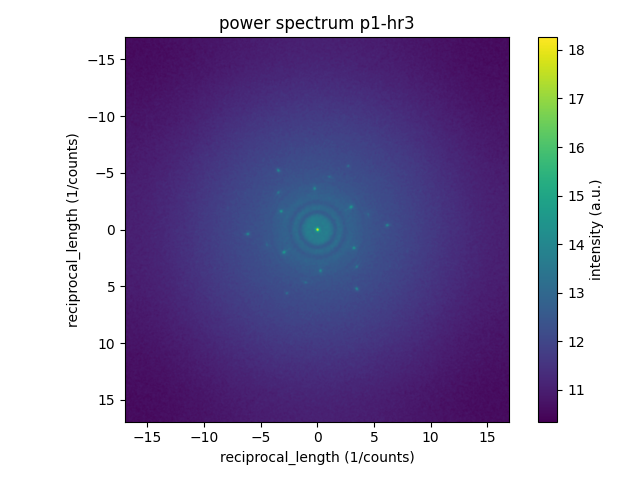

In [6]:
if load_example:
    dataset = datasets['Channel_000']
else:
    dataset = fileWidget.selected_dataset

power_spectrum = image_tools.power_spectrum(dataset)
view = power_spectrum.plot()

### Spot Detection

Found 19 reflections


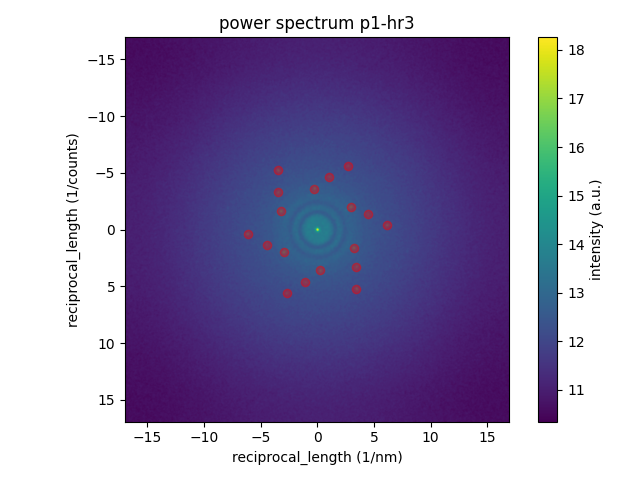

In [7]:
# ------Input----------
spot_threshold = 0.04
# ---------------------
RESOLUTION = 10.0  # in 1/nm

spots = image_tools.diffractogram_spots(power_spectrum, spot_threshold=spot_threshold)

spots = spots[np.linalg.norm(spots[:, :2],axis=1)<RESOLUTION, :]
spots = spots[np.linalg.norm(spots[:, :2],axis=1)>0.5, :]
power_spectrum.u.units = '1/nm'
power_spectrum.plot()

plt.gca().scatter(spots[:,0],spots[:,1], color='red', alpha=0.4);

### Adaptive Fourier Filtering

We mask the fourier transformed image so that the information can pass through is selected.

The information is in the spots and in the center of the Fourier transformed image,the rest is noise.

Please modify the radius of the mask of the **reflections** and the **low-path** area in the code below and notice the effects on the Fourier filtered image.



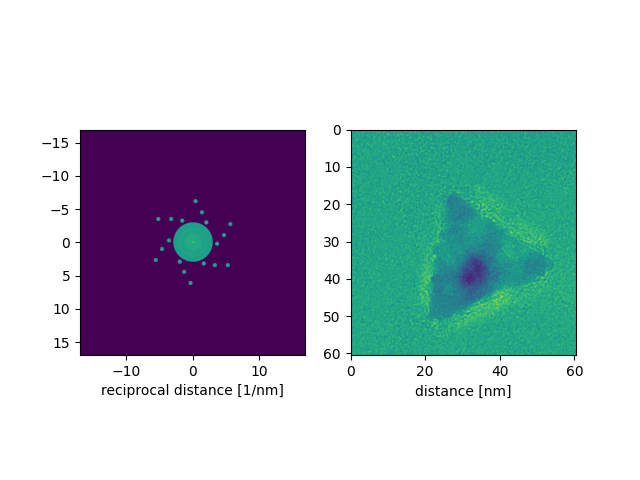

In [8]:
# Input 
reflection_radius = 0.3 # in 1/nm
low_pass = 1/.34 # in 1/nm diameter of mask for low pass filter
FOV_x = dataset.x[-1]
FOV_y = dataset.y[-1]
reciprocal_scale_x = 1/dataset.x[-1]  
reciprocal_scale_y = 1/dataset.y[-1]

## Field of View (FOV) in recipical space please note: rec_FOV_x = 1/(scaleX*2)
reciprocal_FOV_x = reciprocal_scale_x * dataset.shape[0] /2.
reciprocal_FOV_y = reciprocal_scale_y * dataset.shape[1] /2.


## Field ofView (FOV) in recipical space
reciprocal_extend = (-reciprocal_FOV_x, reciprocal_FOV_x, reciprocal_FOV_y, -reciprocal_FOV_y)

#prepare mask
pixels = (np.linspace(0,dataset.shape[0]-1,dataset.shape[0])-dataset.shape[0]/2)* reciprocal_scale_x

x,y = np.meshgrid(pixels,pixels);
mask = np.zeros(dataset.shape)

# mask reflections
for spot in spots:
    mask_spot = (x-spot[0])**2+(y-spot[1])**2 < reflection_radius**2 # make a spot 
    mask = mask + mask_spot# add spot to mask
    
# mask zero region larger (low-pass filter = intensity variations)

mask_spot = x**2+y**2 < low_pass**2 
mask = mask + mask_spot

mask[np.where(mask>1)]=1 # just in case of overlapping disks

plt.figure()
ax1 = plt.subplot(1,2,1)
#ax1.imshow(mask)
fft_filtered = np.fft.fftshift(np.fft.fft2(np.array(dataset)))*mask.T
ax1.imshow(np.log(1+np.abs(fft_filtered)).real,extent=reciprocal_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
ax2 = plt.subplot(1,2,2)
filtered = np.fft.ifft2(np.fft.fftshift(fft_filtered).T)

real_extent = (0,FOV_x,FOV_y,0)
    
ax2.imshow(filtered.real.T,extent=real_extent, origin = 'upper')
plt.xlabel('distance [nm]');


### Check on filtered images

We don't want to filter anything out that caries information, or at least we want to be aware of that. 
An easy check is to subtract the filtered imag fromt he image and to determine that only noise is left.

Please note that any processing can be easily determined in the Fourier transformed, so be meticulous on reporting what you did to an image.


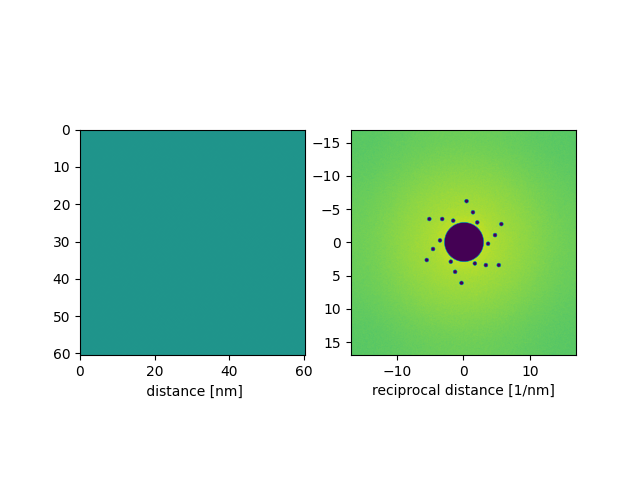

In [9]:
plt.figure()
ax1 = plt.subplot(1,2,1)
ax1.imshow(dataset-filtered.real.T,extent=real_extent, origin = 'upper')
plt.xlabel(' distance [nm]')

ax2 = plt.subplot(1,2,2)
fft_difference = np.fft.fftshift(np.fft.fft2(np.array(dataset-filtered.real.T)))
ax2.imshow(np.log(1+np.abs(fft_difference)).real,extent=reciprocal_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]');

### Rotational Symmetry

In our context of symmetry, we just need to deal with the discrete values of Θ = 2π/n for the angle of rotation.

In two dimensios we have then the rotation matrix:
$$C_{n-fold} = \left[\array{ \cos{( 2\pi/n)} & \sin{( 2\pi/n)}\\ -\sin{( 2\pi/n)} & \cos{ (2\pi/n)}\\}\right]$$

If we subtract all spots from all rotated spots we have a set of distances where for each spot there is minimal distance to the next spot.
If we have a very small distance for each original spot, we have a found rotational symmetry operation.  

In [10]:
from itertools import product

for n in [2,3,4,5,6]:
    C = np.array([[np.cos(2*np.pi/n), np.sin(2*np.pi/n),0],[-np.sin(2*np.pi/n), np.cos(2*np.pi/n),0], [0,0,1]])
    sym_spots = np.dot(spots,C)
    dif = []
    for p0, p1 in product(sym_spots[:,0:2], spots[:,0:2]):
        dif.append(np.linalg.norm(p0-p1))
    dif = np.array(sorted(dif))
    #print(dif[0:spots.shape[0]])
    if dif[int(spots.shape[0]*.7)] < 0.2:
        
        print(f'Found {n}-fold symmetry in diffraction pattern')
        

Found 2-fold symmetry in diffraction pattern
Found 3-fold symmetry in diffraction pattern
Found 6-fold symmetry in diffraction pattern


### Mirror symmetry

Any mirror axis has to go through the origin.

Let's consider the points as vectors and let's condier the miror axis as a vector field that lays on that axis.

The mirror axis of any point has to go through that point plus the half of the vector to another point.


Reflection across a line through the origin in two dimensions can be described by the following formula
$$\operatorname{Ref}_l(v) = 2\frac{v \cdot l}{l \cdot l}l - v,$$

where $v$ is the vector of a point, while $l$ is a vector on the mirror axis on which $v$ is reflected on. $v \cdot l$ denotes the dot product of $v$ and $l$. 


Found 0 mirror axes


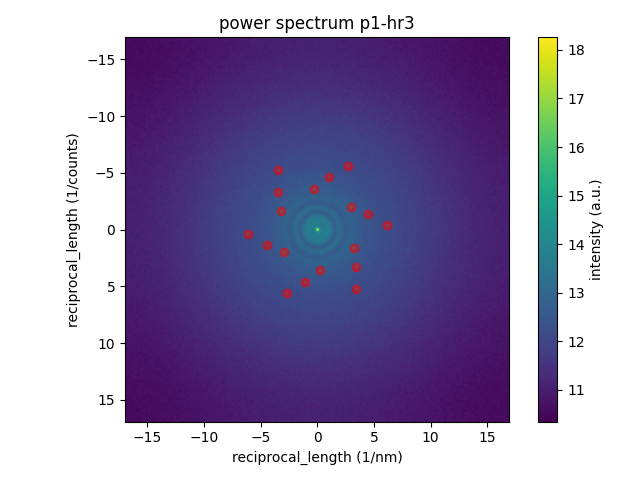

In [11]:
mirror_axes = []
power_spectrum.plot()
plt.scatter(spots[:,0], spots[:,1], c='Red',  alpha = 0.5, label='spots');

for spot in spots:
    if spot[2] > .1:
        mirror_spots = []
        for spot2 in spots:
            if spot2[2]>.1:
                l = spot[0:2]+spot2[0:2]/2
                v = spot[0:2]
                ref = 2*np.dot(v,l) / np.dot(l,l)*l-v
                mirror_spots.append(ref)
        mirror_spots = np.array(mirror_spots)
        dif = []
        for p0, p1 in product(mirror_spots, spots[:,0:2]):
            dif.append(np.linalg.norm(p0-p1))
        dif = np.array(sorted(dif))
        #print(dif[0:25])
        #print(int(spots.shape[0]/2))
        #print(dif[int(spots.shape[0]/2)])
        if dif[int(spots.shape[0]/2)] < 0.5:
            #print(l,dif[0:25])
            mirror_axes.append(l)
            axis=l/np.linalg.norm(l)
            plt.plot([-l[1],l[1]],[-l[0],l[0]],c='yellow')
            print(f'Found mirror {axis} axis in diffraction pattern')
print(f'Found {len(mirror_axes)} mirror axes')


## Quantitative Analysis
### Reference Crystals

In [12]:
graphite  = kinematic_scattering.structure_by_name('Graphite')
zno = kinematic_scattering.structure_by_name('ZnO')
### Define exxperimental parameters:
tags_experiment= {}
tags_experiment['acceleration_voltage_V'] = 200.0 *1000.0 #V
tags_experiment['new_figure'] = False
tags_experiment['plot FOV'] = 30
tags_experiment['convergence_angle_mrad'] = 0
tags_experiment['zone_hkl'] = np.array([0,0,1])  # incident neares zone axis: defines Laue Zones!!!!
tags_experiment['mistilt']  = np.array([0,0,0])  # mistilt in degrees
tags_experiment['Sg_max'] = .02 # 1/Ang  maximum allowed excitation error ; This parameter is related to the thickness
tags_experiment['hkl_max'] = 2  # Highest evaluated Miller indices


######################################
# Diffraction Simulation of Graphite #
######################################
graphite.info['experimental'] = tags_experiment
kinematic_scattering.kinematic_scattering(graphite, False)

######################################
# Diffraction Simulation of ZnO      #
######################################
zno.info['experimental'] = tags_experiment
kinematic_scattering.kinematic_scattering(zno, False)

The diffraciton calculation is in Angstrom (or better 1/Ang) but the image is in nm.
So we convert to 1/nm

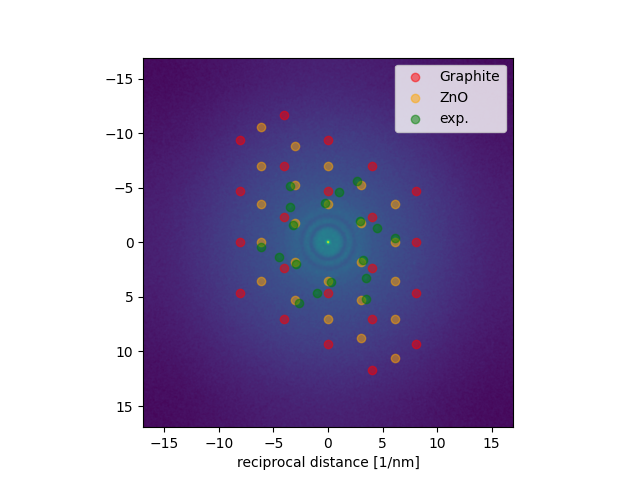

In [13]:

spots_Graphite = graphite.info['diffraction']['allowed']['g']*10
spots_ZnO = zno.info['diffraction']['allowed']['g']*10

resolution = 0.1#nm

plt.figure()
plt.imshow(power_spectrum.T,extent=np.array(reciprocal_extend), origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
plt.scatter(spots_Graphite[:,0], spots_Graphite[:,1], c='Red',  alpha = 0.5, label='Graphite');
plt.scatter(spots_ZnO[:,0], spots_ZnO[:,1], c='orange',  alpha = 0.5, label='ZnO');
plt.scatter(spots[:,0], spots[:,1], c='green',  alpha = 0.5, label='exp.');

plt.legend(loc=1);

### Reflections in Polar Coordinates 
A more interesting way of comparing a simulation and experiment is to compare the spots in polar coordinates:

conversion to Euclidean space:
$$\begin{align}
  x &= r \cos\varphi \\
  y &= r \sin\varphi
\end{align}$$

conversion to polar coordinates:
$$\begin{align}
r &= \sqrt{x^2 + y^2} \\
\varphi &= \operatorname{atan2}(y, x) 
\end{align}$$

Now we can match the reciprocal distances from the center and the angles to match the diffraction pattern with a simulated Bragg peaks

-0.2914567944773926 7
2.548422137392726 0
 Rotated Graphite SAD by -16.7°
 Rotated ZnO SAD by 146.0°


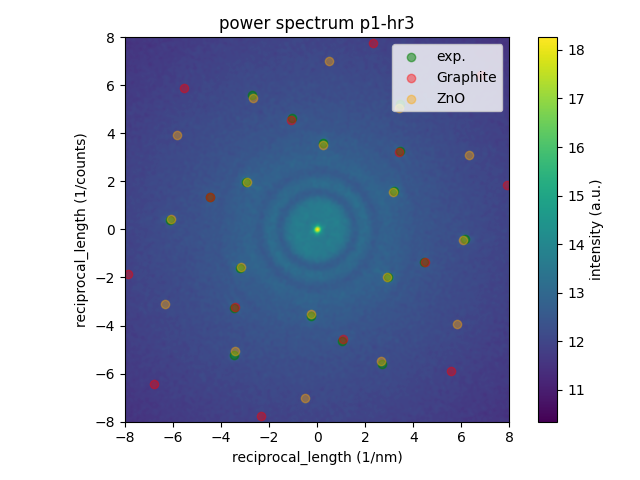

In [14]:
rotation_matrix_graphite, angle_graphite = image_tools.get_rotation(spots, spots_Graphite)
rotation_matrix_ZnO, angle_ZnO = image_tools.get_rotation(spots, spots_ZnO)

graphite_r, graphite_phi, graphite_indices = image_tools.xy2polar(spots_Graphite)
graphite_phi = graphite_phi + angle_graphite # rotation
print(f" Rotated Graphite SAD by {np.degrees(angle_graphite):.1f}°")

ZnO_r, ZnO_phi, ZnO_indices = image_tools.xy2polar(spots_ZnO)
ZnO_phi = ZnO_phi + angle_ZnO # rotation
print(f" Rotated ZnO SAD by {np.degrees(angle_ZnO):.1f}°")

power_spectrum.plot()
plt.scatter(spots[:,0], spots[:,1], c='green',  alpha = 0.5, label='exp.');

spots_Graphite = np.array(image_tools.pol2cart(graphite_r, graphite_phi)).T
plt.scatter(spots_Graphite[:,0], spots_Graphite[:,1], c='red',  alpha = 0.4,label='Graphite')

spots_ZnO = np.array(image_tools.pol2cart(ZnO_r, ZnO_phi)).T
plt.scatter(spots_ZnO[:,0], spots_ZnO[:,1], c='orange',  alpha = 0.4,label='ZnO')


plt.xlim(-8,8);plt.ylim(-8,8)
plt.legend(loc=1);

### Calibrate Distortions with Reference Crystal

We can use to calibrate the image with the Bragg peaks 

In [15]:
g = gx = gy = reciprocal_scale_x

spots_reference = np.array(image_tools.pol2cart(graphite_r, graphite_phi)).T
#spots_reference = np.array(pol2cart(ZnO_r, ZnO_phi)).T

spots_experiment = spots[:,0:2]
dist_graphite = np.linalg.norm(spots_reference, axis=1)

distance_experiment = np.linalg.norm(spots_experiment, axis=1)
first_reflections = abs(distance_experiment - dist_graphite.min()) < .1
print('Evaluate ', first_reflections.sum(), 'reflections')
reference_reflections = spots_experiment[first_reflections]

import scipy.optimize as optimization
def func(params, xdata, ydata):
    dgx , dgy = params
    return (np.sqrt((xdata*dgx)**2 + (ydata*dgy)**2 ) - dist_graphite.min())

x0 = [1.,0.999]
[dgx, dgy], sig = optimization.leastsq(func, x0, args=(reference_reflections[:,0], reference_reflections[:,1]))

print('distortion x:', dgx, 'y: ', dgy) 
gx /=dgx
gy /=dgy

spots_experiment = spots_experiment*(dgx,dgy)


Evaluate  6 reflections
distortion x: 1.0012249778474078 y:  0.9780189341582991


### Plot Corrected Image and Reference Lattice

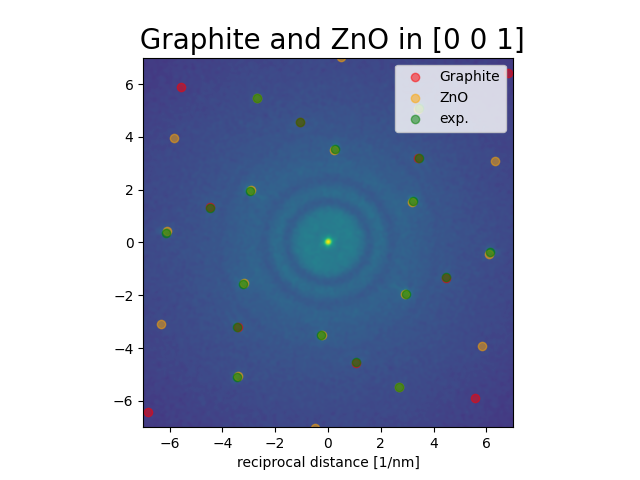

In [16]:
FOV_cor = (0,FOV_x/dgx,FOV_y/dgy,0)
rec_FOV_cor = (-reciprocal_FOV_x*dgx,reciprocal_FOV_x*dgx,reciprocal_FOV_y*dgy,-reciprocal_FOV_y*dgy)

plt.figure()
plt.title(' Graphite and ZnO in ' + str(graphite.info['experimental']['zone_hkl']), fontsize=20)     

plt.imshow(power_spectrum.T,extent=rec_FOV_cor, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
plt.scatter(spots_Graphite[:,0], spots_Graphite[:,1], c='Red',  alpha = 0.5, label='Graphite');
plt.scatter(spots_ZnO[:,0], spots_ZnO[:,1], c='orange',  alpha = 0.5, label='ZnO');
plt.scatter(spots[:,0]*dgx, spots[:,1]*dgy, c='green',  alpha = 0.5, label='exp.');

plt.xlim(-7,7)
plt.ylim(-7,7)
plt.legend(loc=1);


### Plot Histograms of Distances

Next we want to plot the radially summed profile of the diffractogram and compare it with the contrast transfer function.

### Plot Distances and CTF

Scherzer defocus is -271.3 nm


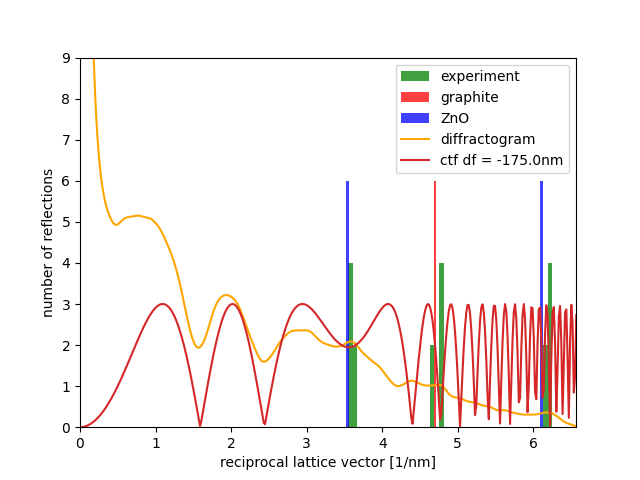

In [17]:
# --------- Input -----------
Cs = 2.2
defocus = -175 # underfocus is negative
acceleration_voltage = 200*1e3
# ---------------------------------
wavelength = kinematic_scattering.get_wavelength(acceleration_voltage) # in nm


polar_projection = image_tools.warp(power_spectrum, np.array([int(dataset.shape[0]/2), int(dataset.shape[1]/2),1] ))
below_zero = polar_projection<0.
polar_projection[below_zero]=0.

# Sum over all angles (axis 1)
profile = polar_projection.sum(axis=1)
profile = (profile-profile[1:400].min())/profile.max()*10


k =np.linspace(1,len(profile),len(profile))*reciprocal_scale_x


def calculateScherzer(wavelength, Cs):
    # Calculate the Scherzer defocus. Cs is in mm, lambda is in nm
    # Everything is transfered to m
    #The returned value is in nm
    Cs=Cs*1e-3 # now in m
    scherzer=-1.155*(Cs*wavelength*1e-9)**0.5 # in m
    scherzer=scherzer*1e9 # convert to nm
    return scherzer

scherzer =calculateScherzer(wavelength, Cs)

print(f'Scherzer defocus is {scherzer:.1f} nm')

def calculateCTF(wavelength, Cs, defocus,k3):
    # everything in nm
    Cs=Cs*10**6
    ctf=np.sin(np.pi*defocus*wavelength*k**2+0.5*np.pi*Cs*wavelength**3*k**4)
    return ctf
ctf = calculateCTF(wavelength/10, Cs, defocus,k)


fig = plt.figure()
exp_r, _ = image_tools.cart2pol(spots)
plt.hist(exp_r, 45, facecolor='green', alpha=0.75, label='experiment')
plt.hist(graphite_r, 200, facecolor='red', alpha=0.75, label='graphite')
plt.xlim(0, exp_r.max()*1.05)

plt.hist(ZnO_r,200,facecolor='blue', alpha=0.75, label='ZnO')
plt.plot(k,profile/profile.max()*20,c='orange',label='diffractogram' );
plt.plot(k,np.abs(ctf)*3, label = f'ctf df = {defocus:.1f}nm')
#plt.hist(np.linalg.norm(p_ZnO, axis=1),200,facecolor='orange', alpha=0.75, label='hexagonal ZnO')
plt.legend()
plt.xlabel('reciprocal lattice vector [1/nm]')
plt.ylabel('number of reflections')

plt.ylim(0,9)

plt.show()

## Another Image
Go back to [Load an atomic resolution image](#Load-an-atomic-resolution-image)

Try the same procedure with image **p1-hr4-ZnOonGraphite.dm3** in the TEMdata directory, which is taken with a different defocus (which one?)

## Conclusion:
We see that we can calibrate an image with sub pm precission if the lattice of a reference crystal is resolved.
The original image scale and distortion was accurate within less than 2%. A quite respectable result, if one takes into account that the objective stigmators and the objecitve focus vary from image to image. These electron optic values will change the magnification of course. 

This will not be possible in a scanning transmission electron microscop HAADF image, due to sample drift and instabilities.